## Task 2. 
Develop your own GAN to model data generated as follows:

$$\begin{eqnarray} \theta & \sim & {\cal U}(0,2\pi) \\
                      r      & \sim & {\cal N}(0, 1) \\
                      \mathbf{x} & \leftarrow & \begin{cases} \begin{bmatrix} (10+r)\cos\theta \\ (10+r)\sin\theta + 10\end{bmatrix} & \frac{1}{2}\pi \le \theta \le \frac{3}{2}\pi \\ \begin{bmatrix} (10+r)\cos\theta \\ (10+r)\sin\theta - 10\end{bmatrix} & \mathrm{otherwise} \end{cases} \end{eqnarray} $$

You should create a PyTorch DataSet that generates the 2D data in the `__init__()` method, outputs a sample in the `__getitem__()` method, and returns the dataset size in the `__len__()` method. 

Use the vanilla GAN approach above with an appropriate structure for the generator. 

Can your GAN generate a convincing facsimile of a set of samples from the actual distribution?

## On SNAKE data,

### The optimizers used are:

        d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))<br>
        g_optimizer = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))

### loss function:

        loss = nn.BCELoss()

NOTE: Tanh() activation function in Generator is removed due to the data range of SNAKE dataset. 

Tanh limits the range to be in between [-1,1] which is not suitable for the dataset of SNAKE. 

In [1]:
import os
import numpy as np
import errno
import torchvision.utils as vutils
from tensorboardX import SummaryWriter
from IPython import display
from matplotlib import pyplot as plt
import torch

'''
    TensorBoard Data will be stored in './runs' path
'''

class Logger:

    def __init__(self, model_name, data_name):
        self.model_name = model_name
        self.data_name = data_name

        self.comment = '{}_{}'.format(model_name, data_name)
        self.data_subdir = '{}/{}'.format(model_name, data_name)

        # TensorBoard
        self.writer = SummaryWriter(comment=self.comment)

    def log(self, d_error, g_error, epoch, n_batch, num_batches):

        # var_class = torch.autograd.variable.Variable
        if isinstance(d_error, torch.autograd.Variable):
            d_error = d_error.data.cpu().numpy()
        if isinstance(g_error, torch.autograd.Variable):
            g_error = g_error.data.cpu().numpy()

        step = Logger._step(epoch, n_batch, num_batches)
        self.writer.add_scalar(
            '{}/D_error'.format(self.comment), d_error, step)
        self.writer.add_scalar(
            '{}/G_error'.format(self.comment), g_error, step)

    def log_images(self, images, num_images, epoch, n_batch, num_batches, format='NCHW', normalize=True):
        '''
        input images are expected in format (NCHW)
        '''
        if type(images) == np.ndarray:
            images = torch.from_numpy(images)
        
        if format=='NHWC':
            images = images.transpose(1,3)
        

        step = Logger._step(epoch, n_batch, num_batches)
        img_name = '{}/images{}'.format(self.comment, '')

        # Make horizontal grid from image tensor
        horizontal_grid = vutils.make_grid(
            images, normalize=normalize, scale_each=True)
        # Make vertical grid from image tensor
        nrows = int(np.sqrt(num_images))
        grid = vutils.make_grid(
            images, nrow=nrows, normalize=True, scale_each=True)

        # Add horizontal images to tensorboard
        self.writer.add_image(img_name, horizontal_grid, step)

        # Save plots
        self.save_torch_images(horizontal_grid, grid, epoch, n_batch)

    def save_torch_images(self, horizontal_grid, grid, epoch, n_batch, plot_horizontal=True):
        out_dir = './data/images/{}'.format(self.data_subdir)
        Logger._make_dir(out_dir)

        # Plot and save horizontal
        fig = plt.figure(figsize=(16, 16))
        plt.imshow(np.moveaxis(horizontal_grid.numpy(), 0, -1))
        plt.axis('off')
        if plot_horizontal:
            display.display(plt.gcf()) #get current axis
        self._save_images(fig, epoch, n_batch, 'hori')
        plt.close()

        # Save squared
        fig = plt.figure()
        plt.imshow(np.moveaxis(grid.numpy(), 0, -1))
        plt.axis('off')
        self._save_images(fig, epoch, n_batch)
        plt.close()

    def _save_images(self, fig, epoch, n_batch, comment=''):
        out_dir = './data/images/{}'.format(self.data_subdir)
        Logger._make_dir(out_dir)
        fig.savefig('{}/{}_epoch_{}_batch_{}.png'.format(out_dir,
                                                         comment, epoch, n_batch))

    def display_status(self, epoch, num_epochs, n_batch, num_batches, d_error, g_error, d_pred_real, d_pred_fake):
        
        # var_class = torch.autograd.variable.Variable
        if isinstance(d_error, torch.autograd.Variable):
            d_error = d_error.data.cpu().numpy()
        if isinstance(g_error, torch.autograd.Variable):
            g_error = g_error.data.cpu().numpy()
        if isinstance(d_pred_real, torch.autograd.Variable):
            d_pred_real = d_pred_real.data
        if isinstance(d_pred_fake, torch.autograd.Variable):
            d_pred_fake = d_pred_fake.data
        
        
        print('Epoch: [{}/{}], Batch Num: [{}/{}]'.format(
            epoch,num_epochs, n_batch, num_batches)
             )
        print('Discriminator Loss: {:.4f}, Generator Loss: {:.4f}'.format(d_error, g_error))
        print('D(x): {:.4f}, D(G(z)): {:.4f}'.format(d_pred_real.mean(), d_pred_fake.mean()))

    def save_models(self, generator, discriminator, epoch):
        out_dir = './data/models/{}'.format(self.data_subdir)
        Logger._make_dir(out_dir)
        torch.save(generator.state_dict(),
                   '{}/G_epoch_{}'.format(out_dir, epoch))
        torch.save(discriminator.state_dict(),
                   '{}/D_epoch_{}'.format(out_dir, epoch))

    def close(self):
        self.writer.close()

    # Private Functionality

    @staticmethod
    def _step(epoch, n_batch, num_batches):
        return epoch * num_batches + n_batch

    @staticmethod
    def _make_dir(directory):
        try:
            os.makedirs(directory)
        except OSError as e:
            if e.errno != errno.EEXIST:
                raise

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/usr/local/lib/python3.8/dist-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: /usr/local/lib/python3.8/dist-packages/torchvision/image.so: undefined symbol: _ZNK3c1010TensorImpl36is_contiguous_nondefault_policy_implENS_12MemoryFormatE
  warn(f"Failed to load image Python extension: {e}")


## Vanilla GAN for SNAKE dataset

Next we'll download the MNIST dataset as a small dataset we can get things running on quickly:

#### 3.1 SNAKE dataset class

In [2]:
import numpy as np
import torch 
class snake_dataset():
    
    def __init__(self, num_sample = 1000):
        self.pi = np.pi
        self.num_sample = num_sample
        self.r = torch.randn(self.num_sample,1)
        self.theta = torch.FloatTensor(self.num_sample,1).uniform_(0,2*self.pi)
        self.a = 10 + self.r
        self.data = torch.empty(self.num_sample,2)
        #self.label = 0
        # self.Y = torch.empty(self.num_sample,1)
        for i in range(self.num_sample):
            if  0.5* self.pi <= self.theta[i] and self.theta[i] <= (3/2) * self.pi :
                self.a = 10 + self.r[i]
                self.x_data = self.a * torch.cos(self.theta[i])
                self.y_data = (self.a * torch.sin(self.theta[i])) + 10
                self.data[i,0] = self.x_data
                self.data[i,1] = self.y_data

            else:
                self.a = 10 + self.r[i]
                self.x_data = self.a * torch.cos(self.theta[i])
                self.y_data = (self.a * torch.sin(self.theta[i])) - 10
                self.data[i,0] = self.x_data
                self.data[i,1] = self.y_data

        self.len = self.data.shape[0]

    def __getitem__(self, index):
        # return (self.X[index], self.Y[index])
        return self.data[index]

    def __len__(self):
        return self.len

#### 3.2 Generate snake dataset

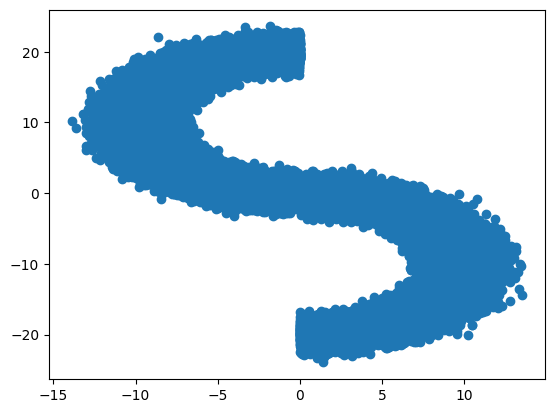

In [3]:
import torch
from torch import nn, optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
# Load Dataset and attach a DataLoader

from dataset_snake import snake_dataset
import matplotlib.pyplot as plt
num_sample = 100000
dataset = snake_dataset(num_sample)
plt.scatter(dataset.data[:,0],dataset.data[:,1])

batch_size=100
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
num_batches = len(data_loader)

#### 3.3 Generator

This "vanilla" GAN is the simplest GAN network architecture.

In [4]:
class GeneratorNet(torch.nn.Module):
    """
    A three hidden-layer generative neural network
    """
    def __init__(self):
        super(GeneratorNet, self).__init__()
        n_features = 2
        n_out = 2
        
        self.hidden0 = nn.Sequential(
            nn.Linear(n_features, 256),
            nn.LeakyReLU(0.2)
        )
        self.hidden1 = nn.Sequential(            
            nn.Linear(256, 256),
            nn.LeakyReLU(0.2)
        )
        self.out = nn.Sequential(
            nn.Linear(256, n_out),
            #nn.Tanh() #Tanh because output image = [0,1]
        )

    def forward(self, x):
        #print("generator")
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.out(x)
        return x

#### 3.4 Discriminator

The discriminator has the responsibity to classify its input as
real or fake. When a fake sample from the generator is given, it should ouptut 0 for fake:

In [5]:
class DiscriminatorNet(torch.nn.Module):
    """
    A three hidden-layer discriminative neural network
    """
    def __init__(self):
        super(DiscriminatorNet, self).__init__()
        n_features = 2
        n_out = 1
        
        self.hidden0 = nn.Sequential( 
            nn.Linear(n_features, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden1 = nn.Sequential(
            nn.Linear(256, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )

        self.out = nn.Sequential(
            torch.nn.Linear(256, n_out),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        #print("discriminator")
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.out(x)
        return x
    
# def images_to_vectors(images):
#     return images.view(images.size(0), 784)

# def vectors_to_images(vectors):
#     return vectors.view(vectors.size(0), 1, 28, 28)

#### 3.5 Create the modules

Let's create an instance of the generator and discriminator:

In [7]:
discriminator = DiscriminatorNet()
generator = GeneratorNet()

device = torch.device('cuda:2') if torch.cuda.is_available() else torch.device("cpu")
print("Configured device: ", device)
#device = 1
if torch.cuda.is_available():
    discriminator.cuda(device)
    generator.cuda(device)

Configured device:  cuda:2


#### 3.6 Set up the optimizers and loss function

In [8]:
# Optimizers

d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Loss function

loss = nn.BCELoss()

# How many epochs to train for

num_epochs = 30

# Number of steps to apply to the discriminator for each step of the generator (1 in Goodfellow et al.)

d_steps = 1

#### 3.7 Training

The targets for the discriminator may be 0 or 1 depending on whether we're giving it
real or fake data:

In [9]:
def real_data_target(size):
    '''
    Tensor containing ones, with shape = size
    '''
    data = torch.ones(size, 1)
    if torch.cuda.is_available(): return data.cuda(device)
    return data

def fake_data_target(size):
    '''
    Tensor containing zeros, with shape = size
    '''
    data = torch.zeros(size, 1)
    if torch.cuda.is_available(): return data.cuda(device)
    return data

Here's a function for a single step for the discriminator:

In [10]:
def train_discriminator(optimizer, real_data, fake_data):
    # Reset gradients
    optimizer.zero_grad()
    
    # Propagate real data
    prediction_real = discriminator(real_data)
    error_real = loss(prediction_real, real_data_target(real_data.size(0)))
    error_real.backward()

    # Propagate fake data
    prediction_fake = discriminator(fake_data)
    error_fake = loss(prediction_fake, fake_data_target(real_data.size(0)))
    error_fake.backward()
    
    # Take a step
    optimizer.step()
    
    # Return error
    return error_real + error_fake, prediction_real, prediction_fake

And here's a function for a single step of the generator:

In [11]:
def train_generator(optimizer, fake_data):
    # Reset gradients
    optimizer.zero_grad()

    # Propagate the fake data through the discriminator and backpropagate.
    # Note that since we want the generator to output something that gets
    # the discriminator to output a 1, we use the real data target here.
    prediction = discriminator(fake_data)
    error = loss(prediction, real_data_target(prediction.size(0)))
    error.backward()
    
    # Update weights with gradients
    optimizer.step()
    
    # Return error
    return error

#### 3.8 Generate test noise samples

Let's generate some noise vectors to use as inputs to the generator.
We'll use these samples repeatedly to see the evolution of the generator
over time.

In [12]:
# Function to create noise samples for the generator's input

def noise(size):
    n = torch.randn(size, 2) #[size vector of length 100]
    if torch.cuda.is_available(): return n.cuda(device) 
    return n

num_test_samples = 100
test_noise = noise(num_test_samples)

#### 3.9 Start training

Now let's train the model:

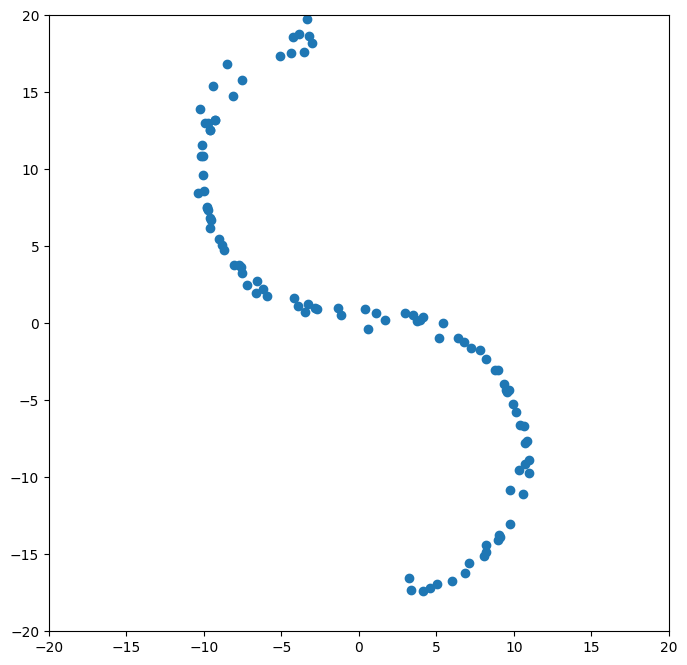

Epoch: [29/30], Batch Num: [990/1000]
Discriminator Loss: 1.3851, Generator Loss: 0.6985
D(x): 0.4976, D(G(z)): 0.4969


In [13]:
def plt_output(fake_data):
    plt.figure(figsize=(8,8))
    plt.xlim(-20,20)
    plt.ylim(-20,20)
    plt.scatter(fake_data[:,0], fake_data[:,1])
    plt.show()

logger = Logger(model_name='VGAN', data_name='SNAKE')

for epoch in range(num_epochs):
    for n_batch, real_batch in enumerate(data_loader):
        # Train discriminator on a real batch and a fake batch
        
        #real_data = images_to_vectors(real_batch)
        real_data = real_batch
        real_data = real_data.cuda(device)
        #if torch.cuda.is_available(): real_data = real_data.cuda(device)
        fake_data = generator(noise(real_data.size(0))).detach()
        d_error, d_pred_real, d_pred_fake = train_discriminator(d_optimizer,
                                                                real_data, fake_data)
        
        # Train generator

        fake_data = generator(noise(real_batch.size(0)))
        g_error = train_generator(g_optimizer, fake_data)
        
        # Log errors and display progress

        logger.log(d_error, g_error, epoch, n_batch, num_batches)
        if (n_batch) % 10 == 0:
            display.clear_output(True)
            # Display Images
            #test_images = vectors_to_images(generator(test_noise)).data.cpu()
            #test_images = generator(test_noise).data.cpu()
            # print(test_images.shape)
            test_plot = plt_output(generator(test_noise).cpu().detach().numpy())
            #logger.log_images(test_images, num_test_samples, epoch, n_batch, num_batches);
            # Display status Logs
            logger.display_status(
                epoch, num_epochs, n_batch, num_batches,
                d_error, g_error, d_pred_real, d_pred_fake
            )
            
        # Save model checkpoints
        logger.save_models(generator, discriminator, epoch)

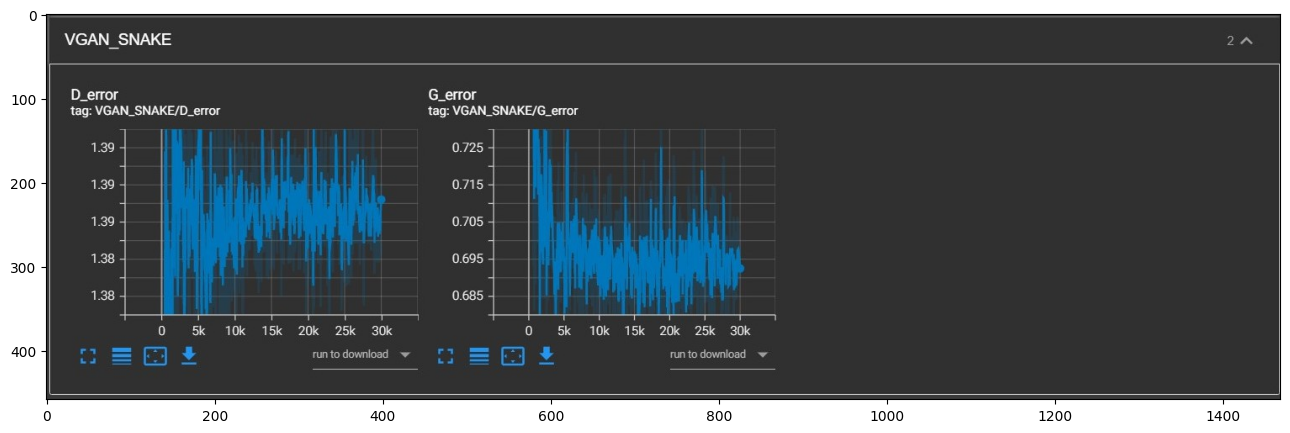

In [4]:
%matplotlib inline  
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread('tensorboard_plot/VGAN_SNAKE.jpg')
plt.figure(figsize=(20,5))
plt.imshow(img)

#### Evaluation on SNAKE

Traing GANs on SNAKE dataset was relatively faster than when on MINIST. That is due to the less complexity of the data. D(x) value when compared to that of the training on MNIST is also better (closer to 0.5) which in turns better reproduction of the input. One thing to note is that due to the different nature of the input, the following functions are not needed: 

        def images_to_vectors(images):
            return images.view(images.size(0), 784)

        def vectors_to_images(vectors):
            return vectors.view(vectors.size(0), 1, 28, 28)